In [1]:
from binance.spot import Spot
import api
import yfinance as yf
import matplotlib.pyplot as plt
import TechnicalIndicators as TA
import Signals as S
import time
import datetime as dt
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, Bounds

# Initialize Binance spot
client = Spot()
client = Spot(key=api.Binance, secret=api.BinanceSecret)

# Converts Binance candlestick data to pandas DataFrame format with correct types and formatted date
def klines_df(Ticker,Time,lim):
    A = client.klines(Ticker,Time,limit=lim)
    for row in A:
        for item in row:
            item = float(item)
        row[0] = dt.datetime.fromtimestamp(float(row[0])/1000)
        for _ in range(6):
            row.pop()
    c = ["Time","Open","High","Low","Close","Volume"]
    df = pd.DataFrame(data=A,columns=c)
    df.Open = df.Open.astype(float)
    df.High = df.High.astype(float)
    df.Low = df.Low.astype(float)
    df.Close = df.Close.astype(float)
    df.Volume = df.Volume.astype(float)
    return df

# Updates existing candlestick data from data/TickerTime.csv
def update(Ticker,Time):
    filename = "data/" + str(Ticker) + str(Time)
    try:
        df = pd.read_csv(filename + ".csv")
        last_time = df.Time.to_list()[-1]
    except:
        udf = klines_df(Ticker,Time,1000)
        udf.to_csv(filename + ".csv")
        return -1
    last_time = dt.datetime.strptime(last_time,'%Y-%m-%d %H:%M:%S')
    udf = klines_df(Ticker,Time,1000)
    udf = udf[udf["Time"] > last_time]
    if (len(udf) == 0): # Nothing to update, so exit
        return -1
    df = df.append(udf)
    df["Index"] = [i for i in range(0,len(df))]
    df.set_index(df.Index,inplace=True)
    df = df.drop("Index",axis=1)
    df.to_csv(filename + ".csv")
    return df

def Balance(x,DF):
    df = DF.copy()
    P = df.Open.to_list()
    Sig = []
    for i, row in df.iterrows():
        s = 0
        for j in range(0,len(x)):
            s += x[j] * row[7+j]
        Sig.append(s)
    if (np.sum(Sig) == 0):
        return 0
    return np.average(P,weights=Sig)

def Iteration(xk, convergence):
    print("xk =",xk,convergence)

In [3]:
df = pd.read_csv("data/BTCUSDT1m.csv")
df["HullMA"] = TA.HullMA(df,60)
df["HullSignal"] = S.HullMA(df,60)
df.head

<bound method NDFrame.head of       Index                 Time      Open      High       Low     Close  \
0         0  2021-08-22 22:51:00  48350.60  48404.69  48336.40  48377.97   
1         1  2021-08-22 22:52:00  48377.97  48396.99  48365.32  48365.33   
2         2  2021-08-22 22:53:00  48365.32  48365.33  48317.94  48317.95   
3         3  2021-08-22 22:54:00  48317.94  48324.59  48317.94  48324.57   
4         4  2021-08-22 22:55:00  48324.57  48340.06  48282.78  48283.25   
...     ...                  ...       ...       ...       ...       ...   
8427   8427  2021-08-28 19:18:00  48992.17  48992.18  48964.93  48990.00   
8428   8428  2021-08-28 19:19:00  48990.00  48990.00  48931.96  48936.84   
8429   8429  2021-08-28 19:20:00  48936.84  48940.99  48910.31  48919.09   
8430   8430  2021-08-28 19:21:00  48919.09  48931.19  48909.10  48911.52   
8431   8431  2021-08-28 19:22:00  48911.52  48915.95  48907.44  48909.58   

         Volume  HullSignal  
0     12.453975           1

In [2]:
# Tickers = ["BTCUSDT","ETHUSDT","ICXUSDT"]
# Times = ["1d","1h","5m","1m"]
# for ticker in Tickers:
#     for time in Times:
#         update(ticker,time)

In [3]:
df = pd.read_csv("data/BTCUSDT1m.csv")
df["Offset15"] = S.Offset(df,15)
df["Offset30"] = S.Offset(df,30)
df["Offset60"] = S.Offset(df,60)
df["Offset90"] = S.Offset(df,90)
df["Offset120"] = S.Offset(df,120)
df["Offset180"] = S.Offset(df,180)
df.dropna(inplace=True)
df.head

<bound method NDFrame.head of       Index                 Time      Open      High       Low     Close  \
179     179  2021-08-23 01:50:00  49317.16  49350.00  49317.15  49335.76   
180     180  2021-08-23 01:51:00  49335.76  49341.77  49270.01  49270.02   
181     181  2021-08-23 01:52:00  49270.02  49270.02  49192.38  49195.00   
182     182  2021-08-23 01:53:00  49195.00  49246.00  49192.23  49241.48   
183     183  2021-08-23 01:54:00  49241.48  49264.87  49220.35  49262.01   
...     ...                  ...       ...       ...       ...       ...   
4001   4001  2021-08-25 17:32:00  48402.30  48427.77  48357.37  48359.74   
4002   4002  2021-08-25 17:33:00  48359.74  48392.51  48357.39  48357.41   
4003   4003  2021-08-25 17:34:00  48357.40  48369.57  48341.24  48344.00   
4004   4004  2021-08-25 17:35:00  48344.00  48379.67  48343.99  48372.04   
4005   4005  2021-08-25 17:36:00  48372.04  48379.96  48345.32  48373.94   

         Volume  Offset15  Offset30  Offset60  Offset90  

In [4]:
B = Bounds((-1,-1,-1,-1,-1,-1),(1,1,1,1,1,1))
result = differential_evolution(Balance,bounds=B,args=(df,),disp=True,callback=Iteration,maxiter=1000)
print(result)

differential_evolution step 1: f(x)= -528977
xk = [-0.798712    0.06439121 -0.28554352 -0.15715131 -0.05021417 -0.07158887] 0.0041698334489110546
differential_evolution step 2: f(x)= -528977
xk = [-0.798712    0.06439121 -0.28554352 -0.15715131 -0.05021417 -0.07158887] 0.0031370609052602506
differential_evolution step 3: f(x)= -3.85533e+06
xk = [-0.07259362 -0.67345315 -0.33081771 -0.09726173  0.14476735 -0.10469967] 0.0006412600854335641
differential_evolution step 4: f(x)= -3.85533e+06
xk = [-0.07259362 -0.67345315 -0.33081771 -0.09726173  0.14476735 -0.10469967] 0.0007996698227153695
differential_evolution step 5: f(x)= -3.85533e+06
xk = [-0.07259362 -0.67345315 -0.33081771 -0.09726173  0.14476735 -0.10469967] 0.0012685396293113718
differential_evolution step 6: f(x)= -3.85533e+06
xk = [-0.07259362 -0.67345315 -0.33081771 -0.09726173  0.14476735 -0.10469967] 0.001496152384549808
differential_evolution step 7: f(x)= -3.85533e+06
xk = [-0.07259362 -0.67345315 -0.33081771 -0.09726173  

<AxesSubplot:>

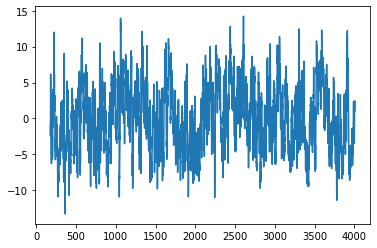

In [5]:
y = result.x
P = df.Open.to_list()
Sig = []
for i, row in df.iterrows():
    s = 0
    for j in range(0,len(y)):
        s += y[j] * row[7+j]
    Sig.append(s)
df["DESignal"] = Sig
df.DESignal.plot()

In [6]:
Ulim = 10
Llim = -10
Sell = df[df["DESignal"] > Ulim]
Buy = df[df["DESignal"] < Llim]
print("Buy:",Buy.Open.mean(),len(Buy))
print("Sell:",Sell.Open.mean(),len(Sell))

Buy: 49152.40007207207 555
Sell: 48834.655132890366 602
